In [1]:
import sys
import re
lb = 0
ub = 1000
names = []
dataset_folder = "more_amazon"
with open(f"{dataset_folder}/dataset_sizes.txt",'r') as f:
    while True:
        first_line = f.readline()
        if not first_line: break
        dataset_name = first_line.split()[1]
        next_line = f.readline()
        nodes, edges = re.findall(r'\d+', next_line)
        nodes, edges = int(nodes), int(edges)
        if nodes >= lb and nodes <= ub:
            names.append(dataset_name)

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '16'

In [3]:
from dsd import fibheap, dsp
from scipy import optimize
import networkx as nx
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

In [4]:
def enumerat(k, upper_bound):
    cur = list(k)
    yield cur
#     while True:
    idx = -1
    while True:
        idx = -1
        cur[idx] += 1
        flag = False
        while cur[idx]>upper_bound[idx]:
            cur[idx] = k[idx]
            idx -=1
            if idx<-len(k):
                flag = True
                break
    #                 flag!!!
            else:
                cur[idx] += 1
        if flag:
            break
        yield list(cur)

def fair_dsd_algorithm4_oneless_iteration(G, k, color_dict, verbose=False, solver='highs-ds', obj_lower_bound=0):
    start_time = time.time()
    n = G.number_of_nodes()
    m = G.number_of_edges()
    global_opt = 0
    global_S = []
    iter_times = 0
    
    for fix_idx in range(len(k)):
        size_upper_bound_by_color = [len(color_dict[i]) for i in range(len(color_dict))]
        size_upper_bound_by_color[fix_idx] = k[fix_idx]
        for p in enumerat(k, size_upper_bound_by_color):
            if verbose:
                print('start the iteration with p=', p)
            iter_start_time = time.time()

            sum_p = sum(p)
            c = [-1.0 for i in range(m)] + [0.0 for i in range(n)]

            Aub = []
            edge_idx = 0
            for e in G.edges():
                tmp_row = [0 for i in range(n+m)]
                tmp_row[edge_idx] = 1.0
                tmp_row[m+e[0]] = -1.0
                Aub.append(tmp_row)
                tmp_row = [0 for i in range(n+m)]
                tmp_row[edge_idx] = 1.0
                tmp_row[m+e[1]] = -1.0
                Aub.append(tmp_row)
                edge_idx += 1
            Bub = [0 for i in range(2*m)]

            Aeq = []
            color_idx = 0
            for color in color_dict:
                tmp_row = [0 for i in range(n+m)]
                for v in color_dict[color]:
                    tmp_row[m+v] = 1.0
                Aeq.append(tmp_row)
            Beq = [float(p[i])/sum_p for i in range(len(color_dict))]

            bounds = [(0.0, 1.0/sum_p) for i in range(m+n)]

            res = optimize.linprog(c, A_ub=Aub, b_ub=Bub, A_eq=Aeq, b_eq=Beq, bounds=bounds, method=solver)
            iter_times+=(time.time() - iter_start_time)
#             print(res['fun'])
            if verbose:
                print('LP finished with return status', res['status'])
            # skip since the LP objective is smaller than previous result or the one from greedy 
            if -res['fun']<max(obj_lower_bound, global_opt):
                continue
            optimal = 0
            opt_S = []
            x = res['x'][:m]
            y = res['x'][m:]
            rs = set(y)-{0}
            for r in rs:
                S = set(np.where(y>=r)[0])
                for color in color_dict:
                    tmp_v_idx = 0
#                     while len(set(color_dict[color])&S)<p[color]:
#                         S.add(color_dict[color][tmp_v_idx])
                    num_need = k[color]-len(set(color_dict[color])&S)
                    if num_need>0:
                        sort_nodes = sorted(list(set(color_dict[color])-S), key=lambda x:len(S&set(G[x])), reverse=True)
                        for i in sort_nodes[:num_need]:
                            S.add(i)
                        tmp_v_idx += 1
                cur_density = G.subgraph(S).number_of_edges()/G.subgraph(S).number_of_nodes()
                if cur_density>optimal:
                    optimal = cur_density
                    opt_S = list(S)
            if verbose:
                print('The optimal density and its corresponding subgraph of this round:', optimal, opt_S)
            if optimal > global_opt:
                global_opt = optimal
                global_S = opt_S
            
#     print('final result:', global_opt, global_S)
    runningtime = time.time()-start_time
#     print('running time:', runningtime, ', avg time each iteration:', sum(iter_times)/len(iter_times))
    return global_opt, global_S, runningtime, iter_times

In [5]:
def check_color(nodes, color_dict, k):
    for i in color_dict:
        if k[i]>=len(set(color_dict[i])&set(nodes)):
            return False
    return True

    
def greedy_by_color(G, color_dict, k, weight=None):
    node_dict, fib_heap, total_degree = dsp.init_heap_flowless_from_graph(G, {})
    Hstar = list(G.nodes())
    n = G.number_of_nodes()
    H = list(G)
    max_avg = float(len(G.edges())) / len(G.nodes())
    new_loads = dict()

    for i in range(n - 1):
        # find min node from graph (remove from heap)
        if not check_color(list(H), color_dict, k):
            break
        to_remove = fib_heap.extract_min()
        node_to_remove = to_remove.value
        degree_to_remove = to_remove.key
        new_loads[node_to_remove] = degree_to_remove

        # for every neighbor node this min node have
        for neighbor in node_dict[node_to_remove][0]:
            edge_w = 1 if weight is None else G[node_to_remove][neighbor][weight]

            # here the key can be actually increased
            if neighbor != node_to_remove:
                fib_heap.decrease_key(node_dict[neighbor][1], node_dict[neighbor][1].key - edge_w)
                node_dict[neighbor][0].remove(node_to_remove)
            total_degree -= edge_w

        del node_dict[node_to_remove]
        avg_degree = total_degree / (n - i - 1)

        if max_avg < avg_degree:
            max_avg = avg_degree
            H = list(node_dict.keys())
    return max_avg, H


In [6]:

def ILP(G, color_dict, k):
    opt = 0
    S = []
    n = len(G.nodes())
    m = len(G.edges())
    min_nodes = sum(k)
    integ = np.array([0 for i in range(m)] + [1 for i in range(n)])
    for t in range(min_nodes, n+1):
        c = np.array([-1.0/t for i in range(m)] + [0.0 for i in range(n)])
        bu = []
        A = []
        edge_c = 0
        for e in G.edges():
            tmp_row = [0.0 for i in range(n+m)]
            tmp_row[edge_c] = 1
            tmp_row[m+e[0]] = -1
            A.append(tmp_row)
            tmp_row = [0.0 for i in range(n+m)]
            tmp_row[edge_c] = 1
            tmp_row[m+e[1]] = -1
            A.append(tmp_row)
            edge_c += 1
            bu = bu + [0,0]

        A.append([0.0 for i in range(m)] + [1.0 for i in range(n)])
        bu.append(t)
        A.append([0.0 for i in range(m)] + [-1.0 for i in range(n)])
        bu.append(-t)

        for color in color_dict:
            tmp_row = [0.0 for i in range(n+m)]
            for i in color_dict[color]:
                tmp_row[m+i] = -1.0
            bu.append(-k[color])
            A.append(tmp_row)
        constraint = optimize.LinearConstraint(A, lb=-np.inf, ub=bu)
        bounds = optimize.Bounds([0.0 for i in range(n+m)], [1.0 for i in range(n+m)])

        res = optimize.milp(c=c, integrality=integ, bounds=bounds, constraints=constraint)
        if res['fun']<opt:
            opt = res['fun']
            S = np.where(res['x'][m:]==1)
#             print(res['fun'])
    return opt, S

In [ ]:
# ipres = []
lpres = []
sizes = []
# ip_time = []
lp_time = []
idx = 0
for i in names:
    if idx>122:
        break
    G = nx.Graph()
    color_dict = {}
    f_g = open(f'{dataset_folder}/{i}.edges', 'r')
    line = f_g.readline()
    line = f_g.readline()
    while line:
        e = line.strip().split(' ')
        G.add_edge(int(e[0]), int(e[1]))
        line = f_g.readline()
    f_c = open(f'{dataset_folder}/{i}.colors', 'r')
    line = f_c.readline()
    while line:
        node_color = line.strip().split(' ')
        if int(node_color[1]) not in color_dict:
            color_dict[int(node_color[1])] = []
        color_dict[int(node_color[1])].append(int(node_color[0]))
        line = f_c.readline()
    ordered_dict = {}
    for j in range(len(color_dict)):
        ordered_dict[j] = color_dict[j]
    k = [int(len(ordered_dict[i])/2) for i in ordered_dict]
        
    start_t = time.time()
    max_avg, H = greedy_by_color(G, ordered_dict, k)
    print('greedy peeling finished. Now start LP solving...')
    print(time.time()-start_t)
    
    global_opt, global_S, runningtime, avg_iter_time = \
            fair_dsd_algorithm4_oneless_iteration(G, k, ordered_dict, verbose=False, obj_lower_bound=max_avg)
    lp_time.append(time.time()-start_t)
    print('dataset', i)
    lpres.append(max(max_avg, global_opt))
    start_t = time.time()
    res = ILP(G, ordered_dict, k)
    ip_time.append(time.time()-start_t)
    print('IP obj:', -res[0])
    ipres.append(-res[0])
    sizes.append(G.number_of_nodes())
#     print('LP obj:', max(max_avg, global_opt), 'KS obj:', kuller_res[idx], 'IP:', ipres[idx])
    print('time:', lp_time[-1], ip_time[idx])
    idx += 1

greedy peeling finished. Now start LP solving...
0.09956812858581543


In [11]:
import os
edge_num = []
for i in names:
    G = nx.Graph()
    color_dict = {}
    f_g = open(f'more_amazon/{i}.edges', 'r')
    line = f_g.readline()
    line = f_g.readline()
    while line:
        e = line.strip().split(' ')
        G.add_edge(int(e[0]), int(e[1]))
        line = f_g.readline()
    edge_num.append(G.number_of_edges())

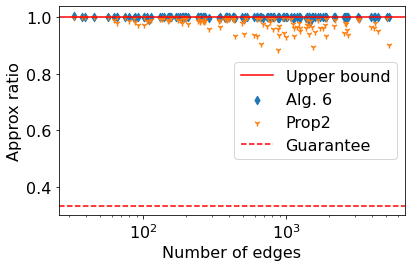

In [109]:
plt.scatter(edge_num[:123], np.array(lpres[:123])/np.array(ipres), label='Alg. 6', marker='d')
plt.scatter(edge_num[:123], np.array(kuller_res[:123])/np.array(ipres), label='Prop2', marker='1')
plt.axhline(y=1, color='r', linestyle='-', label='Upper bound')
plt.axhline(y=1.0/3, color='r', linestyle='--', label='Guarantee')
# plt.scatter(sizes, ipres, label='IP')
plt.xlabel('Number of edges')
plt.ylabel('Approx ratio')
# plt.ylim(0,1.1)
plt.xscale('log')
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [0,2,3,1]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 
# plt.legend()
plt.tight_layout()
plt.savefig('amazon_approxratio_1k.png')
plt.show()

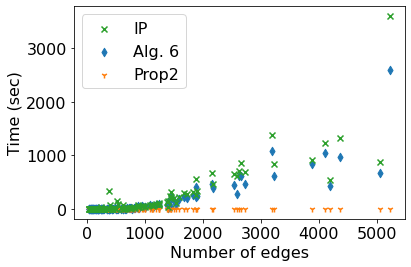

In [110]:
plt.scatter(edge_num[:123], lp_time[:123], label='Alg. 6', marker='d')
plt.scatter(edge_num[:123], kuller_time[:123], label='Prop2', marker='1')
plt.scatter(edge_num[:123], ip_time[:123], label='IP', marker='x')
# plt.scatter(sizes, ipres, label='IP')
plt.xlabel('Number of edges')
plt.ylabel('Time (sec)')
handles, labels = plt.gca().get_legend_handles_labels()

#specify order of items in legend
order = [2,0,1]

#add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 
# plt.legend()
plt.tight_layout()
plt.savefig('amazon_time_1k.png')
plt.show()

In [44]:
def LP_kuller(G, k, color_dict, verbose=False, solver='highs'):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    global_opt = 0
    global_S = []
    sum_k = sum(k)
    l = sum_k
    c = [-1.0 for i in range(m)] + [0.0 for i in range(n)]

    Aub = []
    edge_idx = 0
    for e in G.edges():
        tmp_row = [0 for i in range(n+m)]
        tmp_row[edge_idx] = 1.0
        tmp_row[m+e[0]] = -1.0
        Aub.append(tmp_row)
        tmp_row = [0 for i in range(n+m)]
        tmp_row[edge_idx] = 1.0
        tmp_row[m+e[1]] = -1.0
        Aub.append(tmp_row)
        edge_idx += 1
    Bub = [0 for i in range(2*m)]

    Aeq = [[0 for i in range(m)] + [1.0 for i in range(n)]]
    Beq = [1]

    bounds = [(0.0, 1.0/l) for i in range(m+n)]

    res = optimize.linprog(c, A_ub=Aub, b_ub=Bub, A_eq=Aeq, b_eq=Beq, bounds=bounds, method=solver)
#     if verbose:
#         print('LP finished with return status', res['status'])

    optimal = 0
    opt_S = []
    x = res['x'][:m]
    y = res['x'][m:]
    rs = set(y+[0])
    for r in rs:
        S = set(np.where(y>=r)[0])
        if len(S)<sum_k:
            continue
        cur_density = G.subgraph(S).number_of_edges()/G.subgraph(S).number_of_nodes()
        if cur_density>optimal:
            optimal = cur_density
            opt_S = list(S)
    
    max_avg, H = greedy_kuller(G, color_dict, k)
    if optimal > max_avg:
        global_opt = optimal
        global_S = set(opt_S)
        is_lp = 1
        if verbose:
            print('LP wins with:', optimal)
    else:
        global_opt = max_avg
        global_S = set(H)
        is_lp = 0
        if verbose:
            print('Greedy wins with:', optimal)
    for color in color_dict:
        tmp_v_idx = 0
        if verbose:
            if len(set(color_dict[color])&set(global_S))<k[color]:
                print('Not enough color:', color, ', adding', k[color]-len(set(color_dict[color])&set(global_S)))
            else:
                print('color', color, 'is enough')
        num_need = k[color]-len(set(color_dict[color])&set(global_S))
        if num_need>0:
            sort_nodes = sorted(list(set(color_dict[color])-set(global_S)), key=lambda x:len(set(global_S)&set(G[x])), reverse=True)
            for i in sort_nodes[:num_need]:
                global_S.add(i)
            tmp_v_idx += 1
    return G.subgraph(global_S).number_of_edges()/G.subgraph(global_S).number_of_nodes(), global_S, is_lp

def greedy_kuller(G, color_dict, k, weight=None):
    node_dict, fib_heap, total_degree = dsp.init_heap_flowless_from_graph(G, {})
    Hstar = list(G.nodes())
    n = G.number_of_nodes()
    H = list(G)
    max_avg = float(len(G.edges())) / len(G.nodes())
    new_loads = dict()

    for i in range(n - 1):
        # find min node from graph (remove from heap)
        if n-i<=sum(k):
            break
        to_remove = fib_heap.extract_min()
        node_to_remove = to_remove.value
        degree_to_remove = to_remove.key
        new_loads[node_to_remove] = degree_to_remove

        # for every neighbor node this min node have
        for neighbor in node_dict[node_to_remove][0]:
            edge_w = 1 if weight is None else G[node_to_remove][neighbor][weight]

            # here the key can be actually increased
            if neighbor != node_to_remove:
                fib_heap.decrease_key(node_dict[neighbor][1], node_dict[neighbor][1].key - edge_w)
                node_dict[neighbor][0].remove(node_to_remove)
            total_degree -= edge_w

        del node_dict[node_to_remove]
        avg_degree = total_degree / (n - i - 1)

        if max_avg < avg_degree:
            max_avg = avg_degree
            H = list(node_dict.keys())
    return max_avg, H

In [47]:
kuller_time = []
kuller_res = []
lp_wins = 0
idx = 0
for i in names:
    print(i)
    G = nx.Graph()
    color_dict = {}
    f_g = open(f'more_amazon/{i}.edges', 'r')
    line = f_g.readline()
    line = f_g.readline()
    while line:
        e = line.strip().split(' ')
        G.add_edge(int(e[0]), int(e[1]))
        line = f_g.readline()
    f_c = open(f'more_amazon/{i}.colors', 'r')
    line = f_c.readline()
    while line:
        node_color = line.strip().split(' ')
        if int(node_color[1]) not in color_dict:
            color_dict[int(node_color[1])] = []
        color_dict[int(node_color[1])].append(int(node_color[0]))
        line = f_c.readline()
    ordered_dict = {}
    for j in range(len(color_dict)):
        ordered_dict[j] = color_dict[j]
    k = [int(len(ordered_dict[i])/2) for i in ordered_dict]
        
    start_t = time.time()
    
    global_opt, global_S, is_lp = LP_kuller(G, k, ordered_dict, verbose=False)
    lp_wins += is_lp
    kuller_time.append(time.time()-start_t)
    kuller_res.append(global_opt)
    print(global_opt, ipres[idx])
    idx += 1

All_Electronics__Health_&_Personal_Care__684__416____DUMBBELL_subgraph__
4.568914956011731 4.885906040268456
Luxury_Beauty__Toys_&_Games__173__166____DUMBBELL_subgraph__
1.7794117647058822 1.7906976744186047
Amazon_Home__Gift_Cards__85__46____DUMBBELL_subgraph__
5.851851851851852 5.875
Automotive__Magazine_Subscriptions__176__42____DUMBBELL_subgraph__
2.0491803278688523 2.070175438596491
Amazon_Home__Magazine_Subscriptions__278__126____DUMBBELL_subgraph__
4.541871921182266 4.861111111111111
All_Beauty__Cell_Phones_&_Accessories__228__381____DUMBBELL_subgraph__
4.119718309859155 4.1911764705882355
Magazine_Subscriptions__Toys_&_Games__83__233____DUMBBELL_subgraph__
4.57258064516129 4.595041322314049
Office_Products__Video_Games__115__202____DUMBBELL_subgraph__
6.706896551724138 7.591397849462366
Movies_&_TV__Musical_Instruments__216__235____DUMBBELL_subgraph__
3.207547169811321 3.280821917808219
Baby__Grocery__318__537____DUMBBELL_subgraph__
5.520942408376963 5.845454545454546
Arts,_Cra

3.6553030303030303 3.8040816326530615
Luxury_Beauty__Office_Products__110__105____DUMBBELL_subgraph__
1.8387096774193548 1.8604651162790697
Cell_Phones_&_Accessories__Portable_Audio_&_Accessories__925__351____DUMBBELL_subgraph__
5.171821305841925 5.323529411764706
GPS_&_Navigation__Tools_&_Home_Improvement__72__144____DUMBBELL_subgraph__
1.5666666666666667 1.5862068965517242
GPS_&_Navigation__Industrial_&_Scientific__90__144____DUMBBELL_subgraph__
2.3333333333333335 2.38
Collectibles_&_Fine_Art__Sports_&_Outdoors__249__279____DUMBBELL_subgraph__
11.996527777777779 12.448412698412698
Car_Electronics__GPS_&_Navigation__107__117____DUMBBELL_subgraph__
1.3333333333333333 1.3461538461538463
All_Electronics__Apple_Products__373__40____DUMBBELL_subgraph__
3.4827586206896552 3.4925373134328357
Appliances__Camera_&_Photo__81__22____DUMBBELL_subgraph__
1.391304347826087 1.4285714285714284
Apple_Products__Home_Audio_&_Theater__29__156____DUMBBELL_subgraph__
2.067415730337079 2.0919540229885056
Ma